# Random Forest
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   con     1206 non-null   int64 
 1   wis     1206 non-null   int64 
 2   cha     1206 non-null   int64 
 3   int     1206 non-null   int64 
 4   str     1206 non-null   int64 
 5   book    1206 non-null   object
 6   dex     1206 non-null   int64 
 7   ac      1206 non-null   int64 
 8   level   1206 non-null   int64 
 9   hp      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [4]:
df.head()

,con,wis,cha,int,str,book,dex,ac,level,hp
0,5,2,1,1,7,Pathfinder Bestiary,2,29,10,215
1,5,2,1,-4,9,Pathfinder Bestiary,0,28,10,220
2,6,3,-2,-4,7,Pathfinder Bestiary,3,25,8,175
3,5,5,6,6,7,Pathfinder Bestiary,4,41,17,315
4,1,1,1,-1,-5,Pathfinder Bestiary,3,16,1,20


###### Level

In [5]:
y = df["level"]

In [6]:
print(y)

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64


In [7]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [8]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
print(level_count)

    lvl  count
0    -1     34
1     0     27
2     1    127
3     2    121
4     3     95
5     4     82
6     5     76
7     6     72
8     7     77
9     8     68
10    9     63
11   10     58
12   11     40
13   12     41
14   13     36
15   14     33
16   15     31
17   16     25
18   17     21
19   18     21
20   19     18
21   20     24
22   21     16


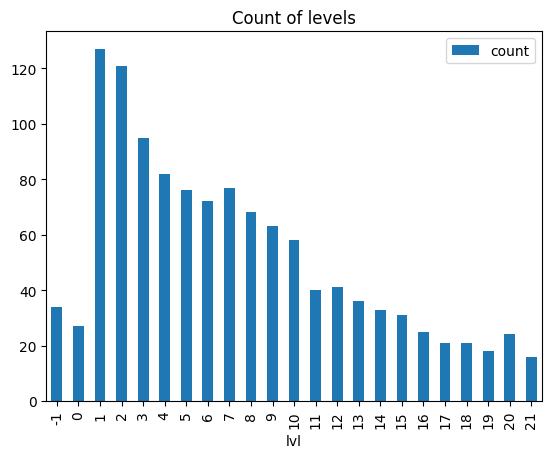

In [9]:
import matplotlib.pyplot as plt

level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [10]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [11]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [12]:
X_train = X_train.astype("int64")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   con     841 non-null    int64
 1   wis     841 non-null    int64
 2   cha     841 non-null    int64
 3   int     841 non-null    int64
 4   str     841 non-null    int64
 5   dex     841 non-null    int64
 6   ac      841 non-null    int64
 7   hp      841 non-null    int64
dtypes: int64(8)
memory usage: 59.1 KB


In [13]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [14]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [15]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## Chronological split

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [17]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.23
RMSE: 1.49


RMSE is large. Let's see value after tuning.

In [19]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.22
RMSE test: 1.49


No overfitting

In [20]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.23
RMSE: 1.49

Round type: round
MSE: 2.52
RMSE: 1.59

Round type: 0.33
MSE: 2.16
RMSE: 1.47

Round type: 0.45
MSE: 2.52
RMSE: 1.59



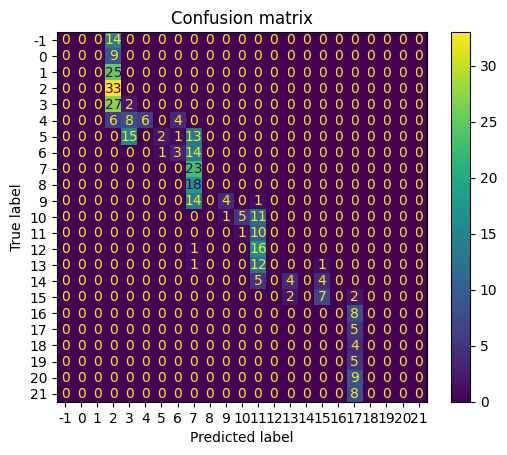

In [21]:
plot_confusion_matrix("round", y_pred_test, y_test)

### Tuning

In [22]:
from training.results import assess_regression_model

In [23]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [24]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   4.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.0s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.7s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 10}

In [25]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.18
RMSE test: 0.67
MSE test: 0.45



(0.6692787837065552, 0.44793409031972603)

### Attempt to decrease overfitting
Change max_depth to 7

In [26]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=100, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.29
RMSE test: 0.71
MSE test: 0.51



(0.7134354767246394, 0.5089901794493135)

Overfitting decreased.

Check rounded predictions

In [27]:
from copy import deepcopy

predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.51
RMSE: 0.71

Round type: round
MSE: 0.53
RMSE: 0.73

Round type: 0.33
MSE: 0.52
RMSE: 0.72

Round type: 0.45
MSE: 0.51
RMSE: 0.72



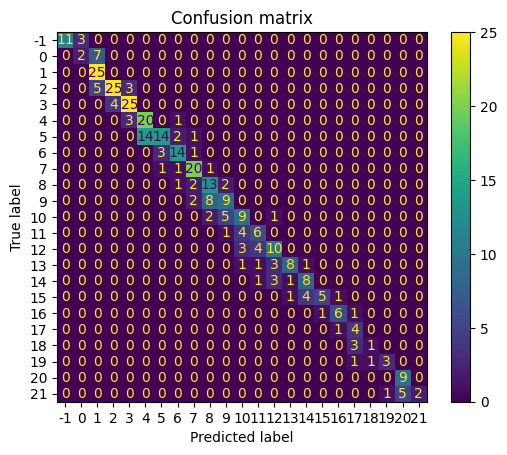

In [28]:
plot_confusion_matrix("round", predict, y_test)

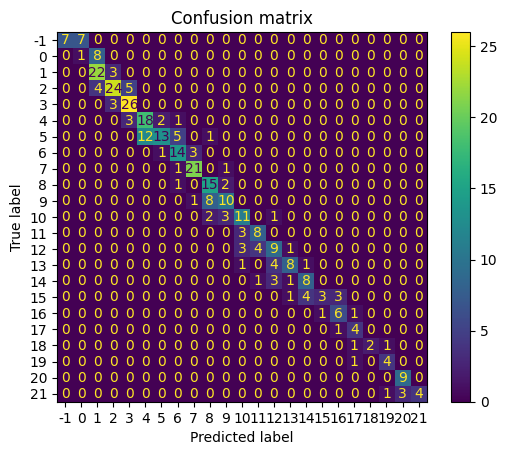

In [29]:
round_predict_33 = np.where(
    (predict % 1) > 0.33, np.ceil(predict), np.floor(predict)
).astype("int")

plot_confusion_matrix("round", round_predict_33, y_test)

The best results for threshold = 0.33

## Random split

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [31]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [32]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.67
RMSE: 1.29


In [33]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.67
RMSE: 1.29

Round type: round
MSE: 1.81
RMSE: 1.35

Round type: 0.33
MSE: 1.82
RMSE: 1.35

Round type: 0.45
MSE: 1.82
RMSE: 1.35



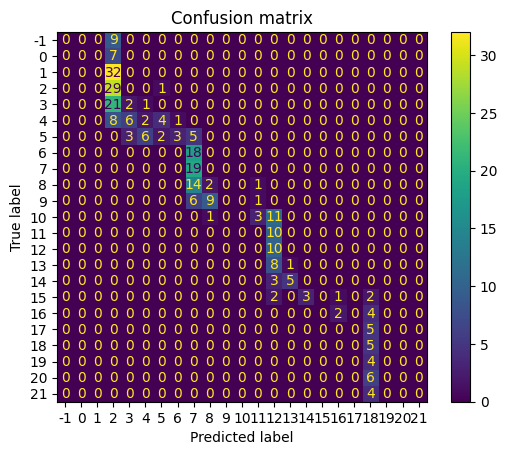

In [34]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [35]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [36]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.2s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.0s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.9s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 10}

In [37]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.20
RMSE test: 0.48
MSE test: 0.23



(0.4769123837554982, 0.2274454217793516)

### Attempt to decrease overfitting
Change max_depth to 7

In [38]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=400, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.45
RMSE test: 0.47
MSE test: 0.22



(0.46684260209977446, 0.21794201513528833)

Check rounded predictions

In [39]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.22
RMSE: 0.47

Round type: round
MSE: 0.23
RMSE: 0.48

Round type: 0.33
MSE: 0.24
RMSE: 0.48

Round type: 0.45
MSE: 0.23
RMSE: 0.48



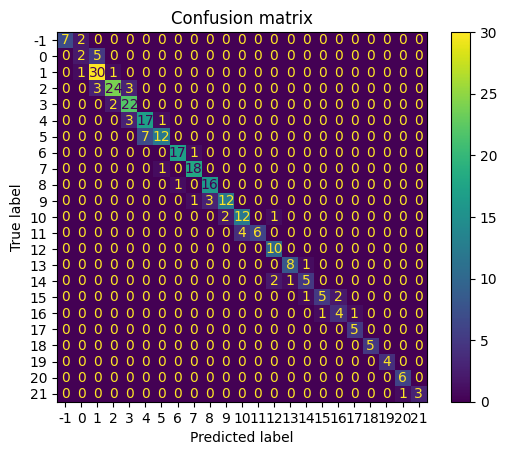

In [40]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

In [41]:
round_predict_33_random_split = np.where(
    (predict_random_split % 1) > 0.33,
    np.ceil(predict_random_split),
    np.floor(predict_random_split),
).astype("int")

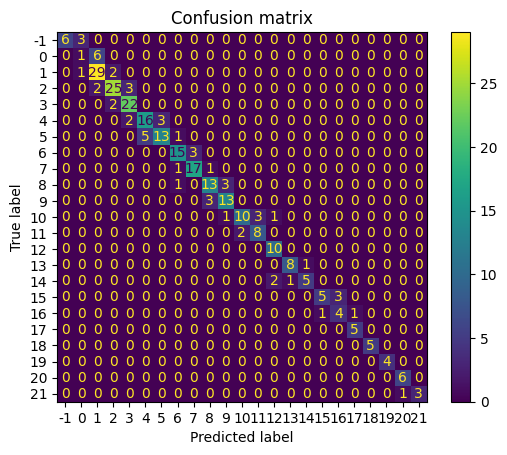

In [42]:
plot_confusion_matrix("round", round_predict_33_random_split, y_test_random_split)

### Podsumowanie:

* Wyniki zadowalające.
* Wyniki poprawiły się względem regesji liniowej.
* Dla podziału chronologicznego dostajemy słabe dopasowanie dla danych testowych. Być może dla większej ilości książek będzie lepiej.

### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [43]:
current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   will        1206 non-null   int64 
 1   con         1206 non-null   int64 
 2   reflex      1206 non-null   int64 
 3   wis         1206 non-null   int64 
 4   cha         1206 non-null   int64 
 5   int         1206 non-null   int64 
 6   str         1206 non-null   int64 
 7   fortitude   1206 non-null   int64 
 8   book        1206 non-null   object
 9   dex         1206 non-null   int64 
 10  perception  1206 non-null   int64 
 11  ac          1206 non-null   int64 
 12  level       1206 non-null   int64 
 13  focus       1206 non-null   int32 
 14  hp          1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [45]:
df.head()

,will,con,reflex,wis,cha,int,str,fortitude,book,dex,perception,ac,level,focus,hp
0,17,5,19,2,1,1,7,22,Pathfinder Bestiary,2,20,29,10,1,215
1,16,5,14,2,1,-4,9,21,Pathfinder Bestiary,0,16,28,10,0,220
2,15,6,17,3,-2,-4,7,20,Pathfinder Bestiary,3,17,25,8,0,175
3,32,5,29,5,6,6,7,30,Pathfinder Bestiary,4,30,41,17,1,315
4,4,1,10,1,1,-1,-5,6,Pathfinder Bestiary,3,6,16,1,1,20


## Train test split

### Chronological split

In [46]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [47]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [48]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [49]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [50]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

### With chronological split

In [51]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [52]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [53]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.12
RMSE: 1.45


In [54]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")  # overfitting

RMSE train: 1.20
RMSE test: 1.45


In [55]:
check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.12
RMSE: 1.45

Round type: round
MSE: 2.38
RMSE: 1.54

Round type: 0.33
MSE: 2.13
RMSE: 1.46

Round type: 0.45
MSE: 2.12
RMSE: 1.46



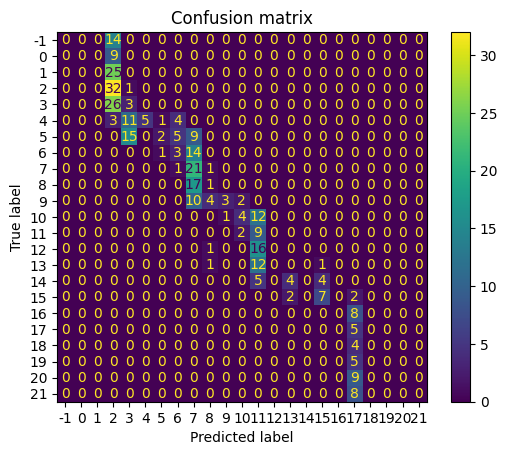

In [56]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [57]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [58]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   0.6s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   0.6s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   0.6s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   0.6s
[CV] END .max_depth=None, max_features=0.1, n_

{'n_estimators': 600, 'max_features': 0.5, 'max_depth': 40}

In [59]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.14
RMSE test: 0.50
MSE test: 0.25



(0.504395097124312, 0.2544144140030441)

In [60]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.25
RMSE: 0.50

Round type: round
MSE: 0.31
RMSE: 0.56

Round type: 0.33
MSE: 0.28
RMSE: 0.53

Round type: 0.45
MSE: 0.29
RMSE: 0.54



### Attempt to decrease overfitting
Change max_depth to 8

In [65]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=600, max_features=0.5, max_depth=8
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.19
RMSE test: 0.51
MSE test: 0.26



(0.5118315279826804, 0.2619715130370853)

In [66]:
predict = rf.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.31
RMSE: 0.56

Round type: 0.45
MSE: 0.31
RMSE: 0.55



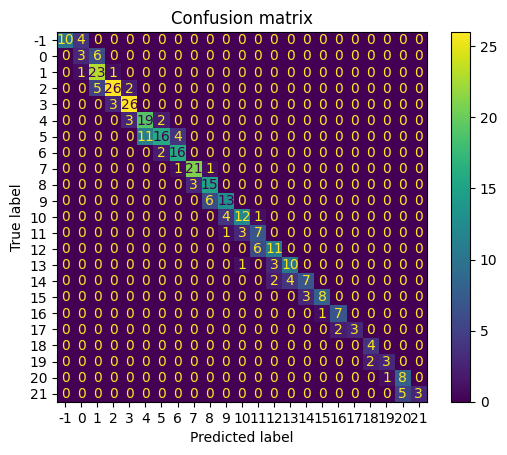

In [67]:
plot_confusion_matrix("round", predict, y_test)

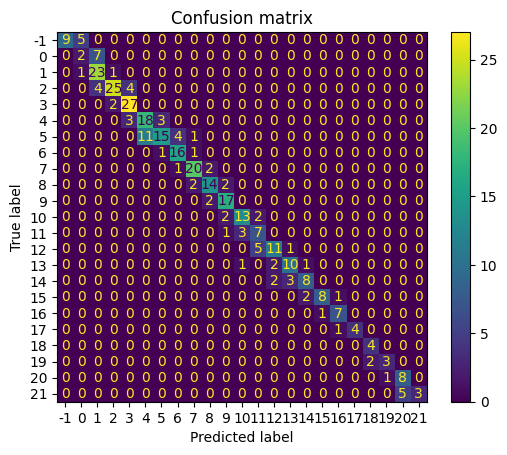

In [68]:
plot_confusion_matrix(0.33, predict, y_test)

### Random split

In [69]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [70]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [71]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.57
RMSE: 1.25


In [72]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.57
RMSE: 1.25

Round type: round
MSE: 1.66
RMSE: 1.29

Round type: 0.33
MSE: 1.68
RMSE: 1.30

Round type: 0.45
MSE: 1.65
RMSE: 1.29



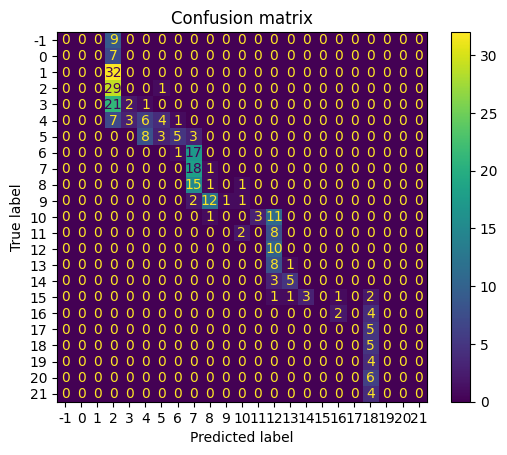

In [73]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

#### Tuning

In [75]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [76]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   2.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.3s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.3s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.9s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [77]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.15
RMSE test: 0.37
MSE test: 0.13



(0.36539119498493194, 0.13351072537251654)

### Attempt to decrease overfitting
Change max_depth to 13

In [85]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=800, max_features=0.5, max_depth=13
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.30
RMSE test: 0.30
MSE test: 0.09



(0.3048560395490865, 0.0929372048495542)

Check rounded predictions

In [86]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.09
RMSE: 0.30

Round type: round
MSE: 0.10
RMSE: 0.32

Round type: 0.33
MSE: 0.10
RMSE: 0.31

Round type: 0.45
MSE: 0.11
RMSE: 0.33



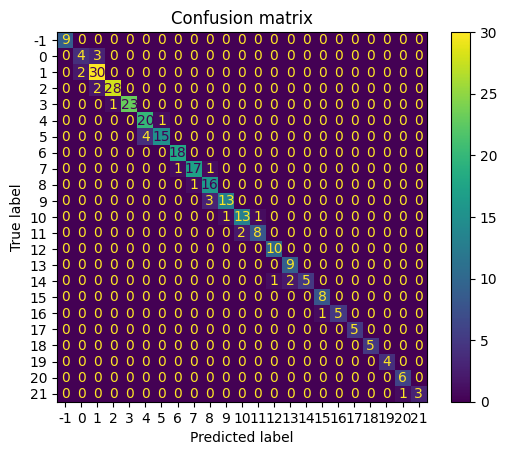

In [87]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

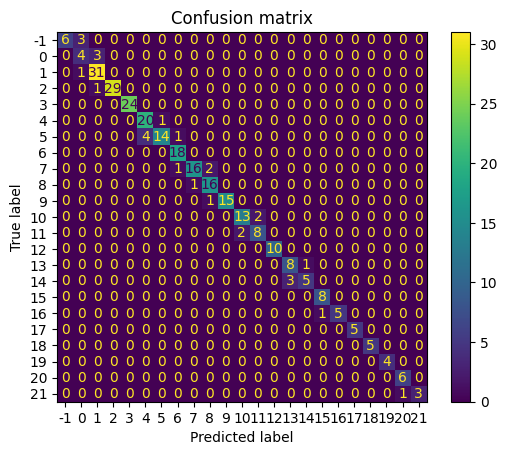

In [88]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [94]:
current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   will                    1206 non-null   int64  
 1   con                     1206 non-null   int64  
 2   reflex                  1206 non-null   int64  
 3   wis                     1206 non-null   int64  
 4   cha                     1206 non-null   int64  
 5   int                     1206 non-null   int64  
 6   str                     1206 non-null   int64  
 7   fortitude               1206 non-null   int64  
 8   book                    1206 non-null   object 
 9   land_speed              1206 non-null   float64
 10  dex                     1206 non-null   int64  
 11  perception              1206 non-null   int64  
 12  num_immunities          1206 non-null   int64  
 13  ac                      1206 non-null   int64  
 14  level                   1206 non-null   

In [96]:
df.head()

,will,con,reflex,wis,cha,int,str,fortitude,book,land_speed,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,17,5,19,2,1,1,7,22,Pathfinder Bestiary,30.0,...,0,0,0,0,0,0,23,22.0,0,0.0
1,16,5,14,2,1,-4,9,21,Pathfinder Bestiary,35.0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,15,6,17,3,-2,-4,7,20,Pathfinder Bestiary,30.0,...,0,0,0,0,0,0,21,16.0,0,0.0
3,32,5,29,5,6,6,7,30,Pathfinder Bestiary,50.0,...,1,0,1,0,0,0,33,31.5,0,0.0
4,4,1,10,1,1,-1,-5,6,Pathfinder Bestiary,0.0,...,1,0,0,0,0,0,0,0.0,8,5.0


## Train test split

### Chronological split

In [97]:
os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [98]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [99]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [100]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [101]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## With chronological split

In [102]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [103]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [104]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 5.05
RMSE: 2.25


In [105]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")  # overfitting

RMSE train: 1.20
RMSE test: 2.25


In [106]:
check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 5.05
RMSE: 2.25

Round type: round
MSE: 5.32
RMSE: 2.31

Round type: 0.33
MSE: 5.02
RMSE: 2.24

Round type: 0.45
MSE: 5.31
RMSE: 2.30



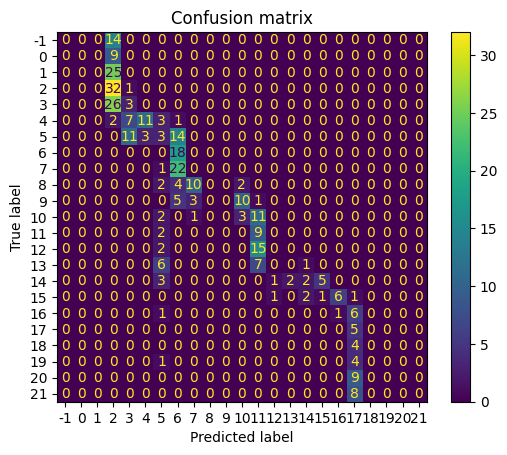

In [107]:
plot_confusion_matrix("round", y_pred_test, y_test)

### Tuning

In [108]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [109]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   2.6s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.7s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.3s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.7s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 700, 'max_features': 0.3, 'max_depth': 80}

In [110]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.13
RMSE test: 0.85
MSE test: 0.72



(0.8478739613899763, 0.718890254403131)

### Attempt to decrease overfitting
Change max_depth to 7 and n_estimators to 500

In [125]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=500, max_features=0.3, max_depth=10
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.14
RMSE test: 0.83
MSE test: 0.69



(0.832791918108465, 0.6935423788667763)

In [126]:
predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.69
RMSE: 0.83

Round type: round
MSE: 0.81
RMSE: 0.90

Round type: 0.33
MSE: 0.64
RMSE: 0.80

Round type: 0.45
MSE: 0.73
RMSE: 0.86



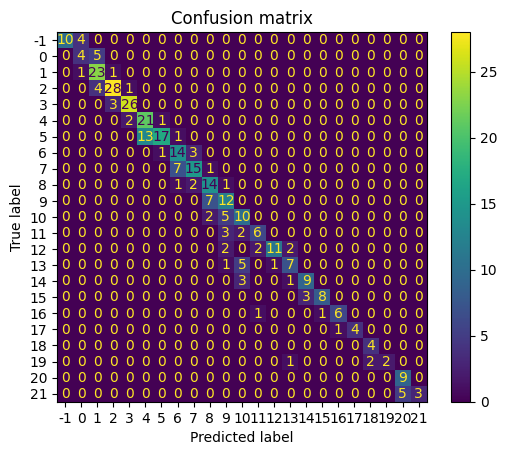

In [127]:
plot_confusion_matrix("round", predict, y_test)

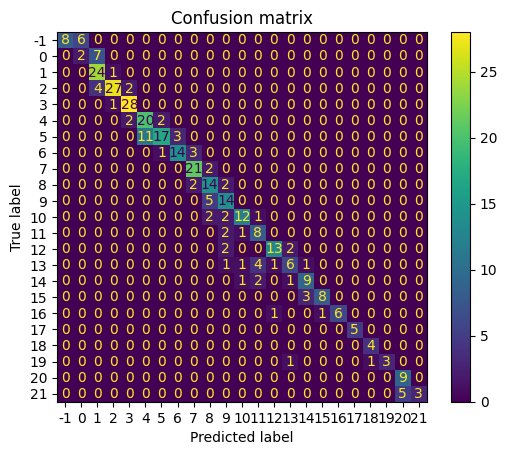

In [128]:
plot_confusion_matrix(0.33, predict, y_test)

## Random split

In [129]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [130]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [131]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.51
RMSE: 1.23


In [132]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.51
RMSE: 1.23

Round type: round
MSE: 1.63
RMSE: 1.28

Round type: 0.33
MSE: 1.63
RMSE: 1.28

Round type: 0.45
MSE: 1.65
RMSE: 1.29



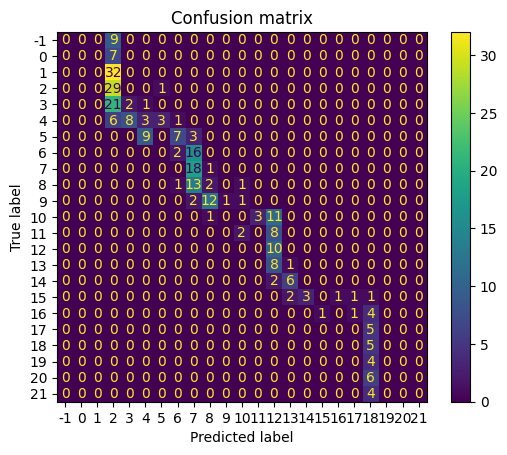

In [133]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [134]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [135]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   2.8s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.2s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.8s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.8s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.6s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 400, 'max_features': 0.3, 'max_depth': None}

In [139]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.14
RMSE test: 0.33
MSE test: 0.11



(0.3340745656247284, 0.11160581539735098)

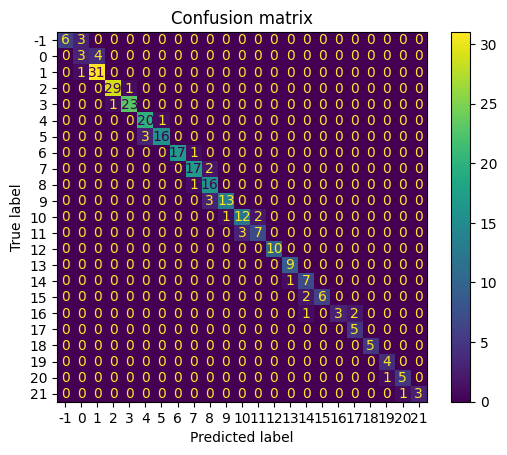

In [154]:
predict_random_split = rf_random.predict(X_test_random_split)
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

### Attempt to decrease overfitting
Change max_depth to 10

In [151]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=400, max_features=0.3, max_depth=None
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.47
RMSE test: 0.48
MSE test: 0.24



(0.48497100428788525, 0.23519687500000003)

Check rounded predictions

In [155]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.24
RMSE: 0.48

Round type: round
MSE: 0.29
RMSE: 0.54

Round type: 0.33
MSE: 0.20
RMSE: 0.45

Round type: 0.45
MSE: 0.25
RMSE: 0.50



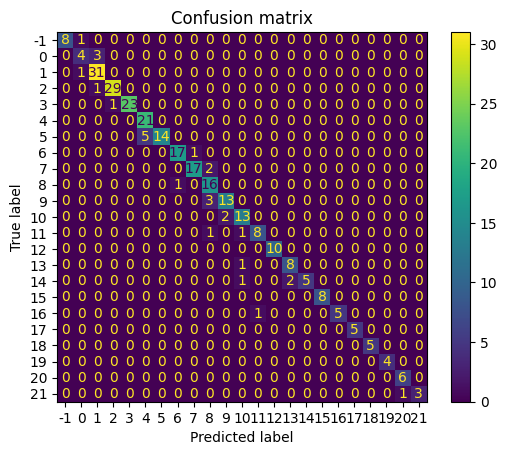

In [156]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

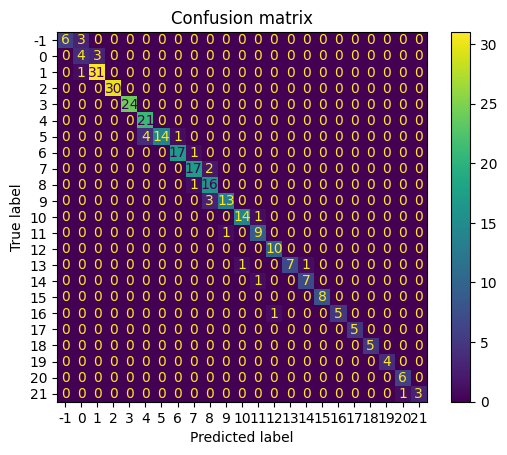

In [158]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)